# ROC and PR Curves

Xuefeng Xu  
2025-07-31

Receiver Operating Characteristic (ROC) and Precision–Recall (PR) curves
are essential for evaluating classification models. They visualize
trade-offs between True Positive Rate (TPR) and False Positive Rate
(FPR) (ROC) or Precision and Recall (PR), offering deeper insights than
single scalar metrics.

## 1 ROC Curve

For binary classification, with Positive (P) and Negative (N) classes,
predictions are based on model scores thresholded to produce labels.
Performance is summarized using a confusion matrix
(<a href="#tbl-confusion-matrix" class="quarto-xref">Table 1</a>),
counting True Positives (TP), False Positives (FP), True Negatives (TN),
and False Negatives (FN).

|     Total=P+N      | Predicted Pos (PP) | Predicted Neg (PN) |         |
|:------------------:|:------------------:|:------------------:|:-------:|
| **Actual Pos (P)** |         TP         |         FN         | P=TP+FN |
| **Actual Neg (N)** |         FP         |         TN         | N=FP+TN |
|                    |      PP=TP+FP      |      PN=FN+TN      |         |

Table 1: The Confusion Matrix

The ROC curve plots TPR vs. FPR, where:

<span id="eq-tpr-fpr">$$
\text{TPR}=\text{TP}/\text{P},\quad \text{FPR}=\text{FP}/\text{N}
 \qquad(1)$$</span>

A simple algorithm constructs the ROC curve: 1) Sort predictions in
descending score order. 2) Sweep thresholds across scores, updating TP
and FP counts (Fawcett 2006).

In [1]:
import numpy as np

def count_fp_tp(y_true, y_score):
    fp, tp = 0, 0
    fps, tps, thresholds = [], [], []
    score = np.inf

    for i in np.flip(np.argsort(y_score)):
        if y_score[i] != score:
            fps.append(fp)
            tps.append(tp)
            thresholds.append(score)
            score = y_score[i]

        if y_true[i] == 1:
            tp += 1
        else:
            fp += 1

    fps.append(fp)
    tps.append(tp)
    thresholds.append(score)
    return np.asarray(fps), np.asarray(tps), np.asarray(thresholds)

def roc_curve(y_true, y_score):
    fps, tps, thresholds = count_fp_tp(y_true, y_score)
    fpr = fps / sum(y_true == 0)
    tpr = tps / sum(y_true == 1)
    return fpr, tpr, thresholds

The ROC curve is always monotonically non-decreasing, starting at
$(0, 0)$ for the highest threshold and ending at $(1, 1)$ for the lowest
threshold. Points are connected using linear interpolation. A random
classifier lies along $y=x$, while curves closer to the top-left
indicate better performance.

In [2]:
import matplotlib.pyplot as plt

def plot_curve(x, y, curve: str, pos_frac=None, drawstyle="default", ax=None):
    if ax is None:
        _, ax = plt.subplots()

    name = f"{curve} curve"
    ax.plot(x, y, "x-", c="C0", label=name, drawstyle=drawstyle)
    ax.set_title(name)

    ax.set_aspect("equal")
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    
    chance = {
        "label": "Chance level",
        "color": "k",
        "linestyle": "--",
    }
    if curve == "ROC":
        ax.plot([0, 1], [0, 1], **chance)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend(loc="lower right")
    elif curve == "PR":  # curve == "PR":
        if pos_frac is not None:
            ax.plot([0, 1], [pos_frac, pos_frac], **chance)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend(loc="lower left")
    elif curve == "PRG":
        ax.set_xlabel("Recall Gain")
        ax.set_ylabel("Precision Gain")
        ax.legend(loc="lower left")
    else:
        raise ValueError(f"Unknown curve type: {curve}")

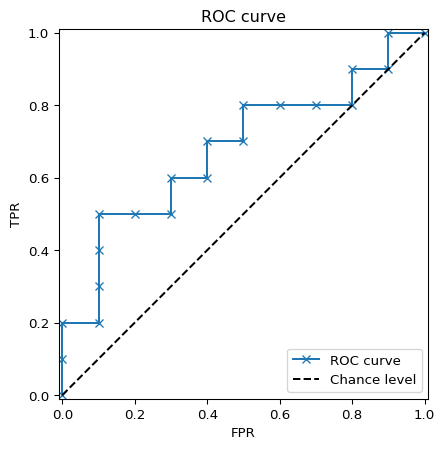

In [3]:
y_true = np.array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])
y_score = np.array([
    .9, .8, .7, .6, .55, .54, .53, .52, .51, .505,
    .4, .39, .38, .37, .36, .35, .34, .33, .3, .1
])

fpr, tpr, _ = roc_curve(y_true, y_score)
plot_curve(fpr, tpr, "ROC")

## 2 ROC Convex Hull

The ROC [Convex Hull](https://en.wikipedia.org/wiki/Convex_hull) (ROCCH)
highlights potentially optimal performance of a classifier (or a set of
classifiers) by connecting upper boundary points (Provost and Fawcett
2001). It can be computed via algorithms like the [Monotone chain
algorithm](https://en.wikibooks.org/wiki/Algorithm_Implementation/Geometry/Convex_hull/Monotone_chain#Python).

In [4]:
def convex_hull(points):
    points = sorted(set(points))

    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    # Build upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)
    
    return upper

``` python
rocch = convex_hull(zip(fpr, tpr))

rocch = np.array(rocch)
fpr_ch, tpr_ch = rocch[:, 0], rocch[:, 1]

fig, ax = plt.subplots()
ax.plot(fpr_ch, tpr_ch, 'C1-.', label="ROCCH")
plot_curve(fpr, tpr, "ROC", ax=ax)
```

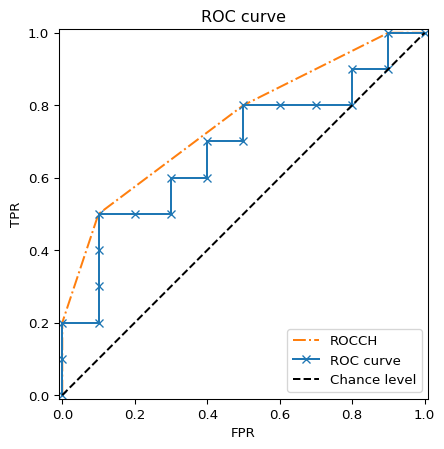

## 3 PR Curve

PR curves plot Precision vs. Recall. Recall equals TPR, while Precision
is:

<span id="eq-prec">$$
\text{Prec}=\frac{\text{TP}}{\text{TP}+\text{FP}}
 \qquad(2)$$</span>

PR curves start at $(0, 1)$ and end at
$(1, \frac{\text{P}}{\text{P}+\text{N}})$, where the endpoint reflects
the proportion of positive samples. Because Precision depends on both TP
and FP, the PR curve is non-monotonic and can decrease as Recall
increases. Moreover, it is highly influenced by class imbalance
(Williams 2021). For a random classifier, the PR curve is a horizontal
line at $y = \frac{\text{P}}{\text{P}+\text{N}}$, whereas curves closer
to the top-right indicate stronger performance.

In [6]:
def pr_curve(y_true, y_score):
    fps, tps, thresholds = count_fp_tp(y_true, y_score)

    pps = fps + tps
    precision = np.ones_like(tps, dtype=np.float64)
    np.divide(tps, pps, out=precision, where=(pps != 0))

    recall = tps / sum(y_true == 1)
    return np.flip(precision), np.flip(recall), np.flip(thresholds)

Although ROC and PR curves are mathematically related, linear
interpolation is incorrect for PR curves, as it yields overly optimistic
estimates of performance (Davis and Goadrich 2006). Precision does not
necessarily vary linearly with Recall, so naive interpolation
misrepresents true model behavior.

To illustrate this, we convert the ROC Convex Hull (ROCCH) into PR
space, treating it as the potential optimal PR curve. Using
<a href="#eq-prec-tpr-fpr" class="quarto-xref">Equation 3</a>, we
express Precision in terms of TPR and FPR:

<span id="eq-prec-tpr-fpr">$$
\text{Prec}=\frac{\text{P}\cdot\text{TPR}}{\text{P}\cdot\text{TPR}+\text{N}\cdot\text{FPR}}
=\frac{1}{1+\frac{\text{N}}{\text{P}}\cdot\frac{\text{FPR}}{\text{TPR}}}
 \qquad(3)$$</span>

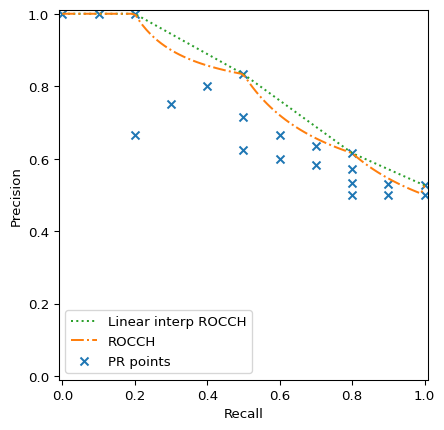

In [7]:
from scipy.interpolate import interp1d

def pr_from_roc(fpr, tpr, neg_to_pos):
    fpr_tpr_func = interp1d(tpr, fpr, bounds_error=False, fill_value=(0, 1))

    def prec_func(tpr):
        fpr = fpr_tpr_func(tpr)
        fpr_to_tpr = np.zeros_like(tpr, dtype=np.float64)
        np.divide(fpr, tpr, out=fpr_to_tpr, where=(tpr != 0))
        prec = 1 / (1 + neg_to_pos * fpr_to_tpr)
        return prec

    return prec_func

neg_to_pos = sum(y_true == 0) / sum(y_true == 1)
prec_ch_func = pr_from_roc(fpr_ch, tpr_ch, neg_to_pos)

fig, ax = plt.subplots()
ax.plot(tpr_ch, prec_ch_func(tpr_ch), 'C2:', label="Linear interp ROCCH")

x = np.linspace(0, 1, 100)
ax.plot(x, prec_ch_func(x), 'C1-.', label="ROCCH")

precision, recall, _ = pr_curve(y_true, y_score)
ax.scatter(recall, precision, c="C0", marker="x", label="PR points")

ax.set_aspect("equal")
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="lower left")

The converted ROCCH dominates the PR space but is clearly non-linear,
lying beneath its own linear interpolation (dotted line). This confirms
that PR curves cannot be linearly interpolated. Scikit-learn’s
[PrecisionRecallDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)
instead uses step-wise interpolation, consistent with
[average_precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html).
This ensures that the area under the PR curve equals the average
precision.

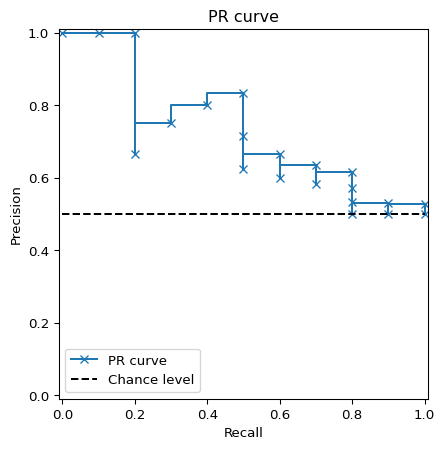

In [8]:
pos_frac = sum(y_true == 1) / len(y_true)
plot_curve(recall, precision, "PR", pos_frac, drawstyle="steps-post")

## 4 PRG Curve

ROC curves benefit from linear interpolation and universal baselines,
whereas PR curves lack these properties. To address this, Flach and Kull
(2015) proposed the Precision–Recall-Gain (PRG) curve, which transforms
Precision and Recall into Gains and plots these Precision Gain and
Recall Gain within the unit square:

<span id="eq-prec-rec-gain">$$
\text{PrecG}=\frac{\text{Prec}-\pi}{(1-\pi)\text{Prec}},\quad
\text{RecG}=\frac{\text{Rec}-\pi}{(1-\pi)\text{Rec}}
 \qquad(4)$$</span>

where $\pi=\frac{\text{P}}{\text{P}+\text{N}}$ is the positive class
fraction. Notably, Gains can be negative, and such points are typically
omitted from the PRG curve.

In [9]:
def prg_curve(y_true, y_score):
    prec, rec, thresholds = pr_curve(y_true, y_score)
    pos_frac = sum(y_true == 0) / len(y_true)

    # Remove negative gains
    mask = (rec >= pos_frac) & (prec >= pos_frac)
    prec = prec[mask]
    rec = rec[mask]

    prec_gain = (prec - pos_frac) / (1 - pos_frac) / prec
    rec_gain = (rec - pos_frac) / (1 - pos_frac) / rec
    return prec_gain, rec_gain, thresholds

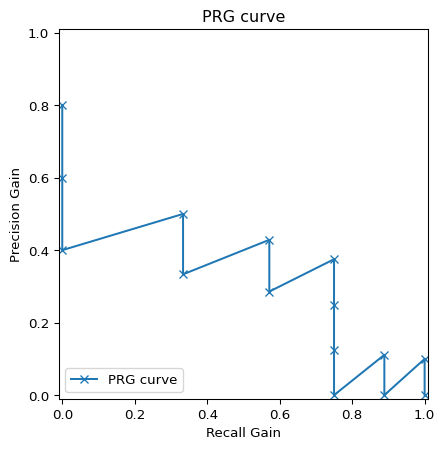

In [10]:
prec_gain, rec_gain, _ = prg_curve(y_true, y_score)
plot_curve(rec_gain, prec_gain, "PRG")

Davis, Jesse, and Mark Goadrich. 2006. “The Relationship Between
Precision-Recall and ROC Curves.” In *Proceedings of the 23rd
International Conference on Machine Learning*, 233–40. ICML ’06. New
York, NY, USA: Association for Computing Machinery.
<https://doi.org/10.1145/1143844.1143874>.

Fawcett, Tom. 2006. “An Introduction to ROC Analysis.” *Pattern
Recognition Letters* 27 (8): 861–74.
<https://doi.org/10.1016/j.patrec.2005.10.010>.

Flach, Peter, and Meelis Kull. 2015. “Precision-Recall-Gain Curves: PR
Analysis Done Right.” In *Advances in Neural Information Processing
Systems*. Vol. 28. Curran Associates, Inc.
<https://papers.nips.cc/paper/5867-precision-recall-gain-curves-pr-analysis-done-right>.

Provost, Foster J., and Tom Fawcett. 2001. “Robust Classification for
Imprecise Environments.” *Machine Learning* 42 (3): 203–31.
<https://doi.org/10.1023/A:1007601015854>.

Williams, Christopher K. I. 2021. “The Effect of Class Imbalance on
Precision-Recall Curves.” *Neural Computation* 33 (4): 853–57.
<https://doi.org/10.1162/neco_a_01362>.